<a href="https://colab.research.google.com/github/dardan-gashi01/IN3060-CW/blob/main/HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'test_functions.ipynb', '.DS_Store', 'CW_Dataset.zip', 'Models', 'Personal_Dataset']


In [ ]:
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

!cp '{zip_path}' .

!yes|unzip -q CW_Dataset.zip

!rm CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

In [ ]:
import os, shutil

def make_dir_if_not_exists(path):
  if not os.path.isdir(path):
    os.mkdir(path)


def dataFolder2(trainImgPath, testImgPath, trainLabelPath, testLabelPath):
  #creating empty folders
  make_dir_if_not_exists('./DataFolder')
  make_dir_if_not_exists('./DataFolder/train')
  make_dir_if_not_exists('./DataFolder/test')
  for i in range(1,8):
    make_dir_if_not_exists(f'./DataFolder/train/{str(i)}')
    make_dir_if_not_exists(f'./DataFolder/test/{str(i)}')

  trainPath = './DataFolder/train'
  testPath = './DataFolder/test'

  file_names = [file for file in os.listdir(trainImgPath) if file.endswith('.jpg')]
  parsed_data = {}
  with open (trainLabelPath, "r") as myfile:
    data = myfile.readlines()
    for line_data in data:
      file_name, number = line_data.strip().split(" ")
      parsed_data[file_name] = number

  for file in file_names:
    shutil.copy(f"{trainImgPath}/{file}", f"{trainPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")
    #print("image file: " + file + ' class: ' + parsed_data[file.replace("_aligned", "")])
  #load images into the correct folders


  file_names = [file for file in os.listdir(testImgPath) if file.endswith('.jpg')]
  parsed_data = {}
  with open (testLabelPath, "r") as myfile:
    data = myfile.readlines()
    for line_data in data:
      file_name, number = line_data.strip().split(" ")
      parsed_data[file_name] = number

  for file in file_names:
    shutil.copy(f"{testImgPath}/{file}", f"{testPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")
    #print("image file: " + file + ' class: ' + parsed_data[file.replace("_aligned", "")])
  #load images into the correct folders

In [ ]:
dataFolder2('train', 'test', 'labels/list_label_train.txt', 'labels/list_label_test.txt')

In [ ]:
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from skimage import exposure

In [ ]:
def import_selected_data(path, label_list):
    """Load images and labels from selected directories"""
    images = []
    labels = []

    if label_list is None:
        folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('.')]
    else:
        folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list]

    for folder in folder_names:
        file_names = [file for file in sorted(os.listdir(os.path.join(path, folder))) if file.endswith('.jpg')]
        for file in file_names:
            images.append(io.imread(os.path.join(path, folder, file)))
            labels.append(folder)

    return images, labels

In [ ]:
X, y = import_selected_data('DataFolder/train', label_list=['1', '2', '3','4','5','6','7'])

In [ ]:
print(Counter(y))

Counter({'4': 4772, '7': 2524, '5': 1982, '1': 1290, '3': 717, '6': 705, '2': 281})


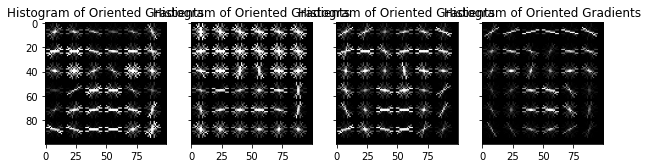

In [ ]:
hog_list = []
hog_features=[]
labels_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharex=True, sharey=True)

for i in range(len(X)):
  img = img_as_ubyte(color.rgb2gray(X[i]))
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

  if i < 4:
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax[i].imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax[i].set_title('Histogram of Oriented Gradients')

  hog_list.append(hog_image)
  labels_list.append(y[i])
  hog_features.append(fd)
 
fig.tight_layout
plt.show()

#hog_array = np.vstack(hog_list)

In [ ]:
np.shape(hog_list)

(12271, 100, 100)

In [ ]:
nsamples, nx, ny = np.shape(hog_list)
hog_list2 = np.reshape(hog_list, (nsamples,nx*ny))

In [ ]:
hog_list2 = np.array(hog_list)

In [ ]:
hog_list2.flatten()

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
hog_list2.shape

(12271, 100, 100)

In [ ]:
classifier = svm.SVC()
X_train, X_test, y_train, y_test = train_test_split(
    hog_list2, labels_list, test_size=0.2, shuffle=True, stratify=labels_list)

In [ ]:
np.shape(X_train)

(9816, 10000)

In [ ]:
np.shape(y_train)

(9816,)

In [ ]:
classifier.fit(X_train, y_train)

ValueError: ignored

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.6533604887983707


              precision    recall  f1-score   support

           1       0.64      0.49      0.55       258
           2       0.90      0.16      0.27        56
           3       0.80      0.03      0.05       143
           4       0.76      0.86      0.81       955
           5       0.55      0.48      0.51       397
           6       0.72      0.43      0.54       141
           7       0.53      0.77      0.63       505

    accuracy                           0.65      2455
   macro avg       0.70      0.46      0.48      2455
weighted avg       0.67      0.65      0.63      2455



In [ ]:
from joblib import dump, load
dump(classifier, os.path.join(GOOGLE_DRIVE_PATH, 'Models/HOGSVM.joblib')) 

['drive/My Drive/Colab Notebooks/CW_Folder_UG/CW_Folder_UG/Models/HOGSVM.joblib']

In [ ]:
np.shape(X_test[0])

(10000,)

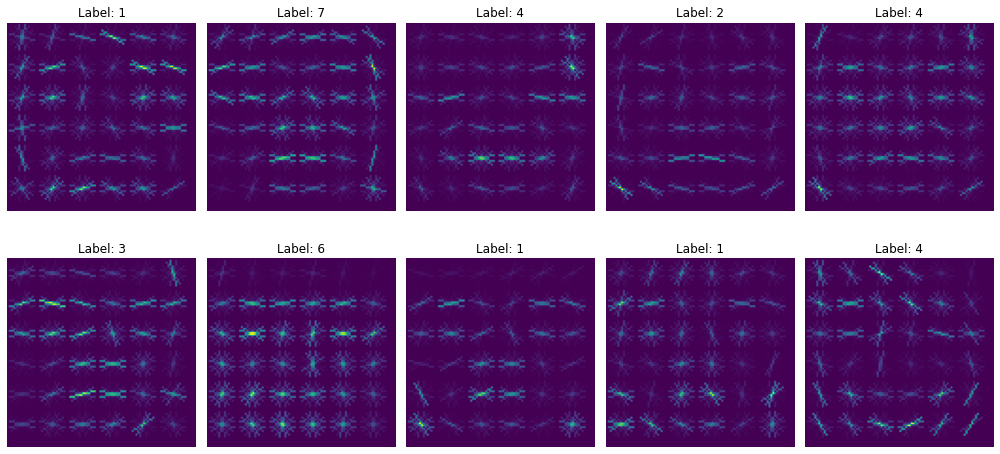

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    
    ax[i].imshow(np.reshape(X_test[i], (100,100)))
    ax[i].set_title(f'Label: {y_test[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y)

In [ ]:
np.shape(X_train)

(9816, 100, 100, 3)

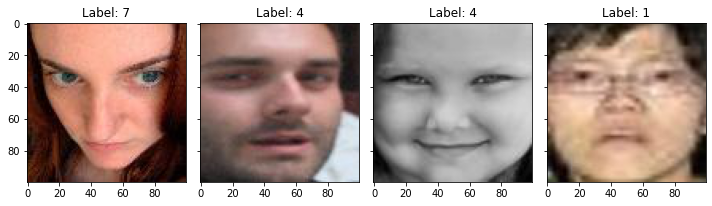

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (10,5), sharex=True, sharey = True)
ax = axes.ravel()

for i in range(4):
  ax[i].imshow(X_train[i], cmap='gray')
  ax[i].set_title(f'Label: {y_train[i]}')
  
fig.tight_layout()
plt.show()

**HOG Feature extractor**

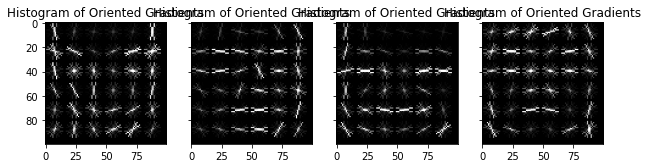

In [ ]:
hog_list = []
hog_features=[]
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharex=True, sharey=True)

for i in range(len(X_train)):
  img = img_as_ubyte(color.rgb2gray(X_train[i]))
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

  if i < 4:
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax[i].imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax[i].set_title('Histogram of Oriented Gradients')

  hog_list.append(hog_image)
  y_train_list.append(y_train[i])
  hog_features.append(fd)
 
fig.tight_layout
plt.show()

hog_array = np.vstack(hog_list)

In [ ]:
hog_array.shape

(981600, 100)

In [ ]:
# Create a classifier: a support vector classifier
classifier = svm.SVC()
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features, ))

ValueError: ignored